In [2]:
import os
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import cv2
import time
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import pandas as pd


from torch.optim import Adam, lr_scheduler
from tqdm.notebook import tqdm
from albumentations import Compose, HorizontalFlip, Resize
from torch.utils.data import Dataset, DataLoader

In [3]:
# structure data from folder in data frame for loading
video_path_real = os.path.join("/home/jupyter/0margin/real/")
video_path_fake = os.path.join("/home/jupyter/0margin/fake/")


data_list = []
for _,_,videos in os.walk(video_path_real):
    for video in tqdm(videos):
        #label 0 for real image
        data_list.append({'label':0, 'image':video})

for _,_,videos in os.walk(video_path_fake):
     for video in tqdm(videos):
            # label 1 for deepfake image
            data_list.append({'label':1, 'image':video})
            
#put data into dataframe
df = pd.DataFrame(data=data_list)

In [4]:
df.head()

,label,image
0,0,0032_16.jpg
1,0,0023_3.jpg
2,0,0000_19.jpg
3,0,0026_3.jpg
4,0,0013_12.jpg


In [5]:
# split into 60% train, 20% val, 20% test
# from https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
train, val, test = np.split(df.sample(frac=1, random_state=24), [int(.6*len(df)), int(.8*len(df))])

In [6]:
train.head()

,label,image
1432,1,0029_fake_12.jpg
25,0,0020_2.jpg
891,0,0015_12.jpg
1376,1,0006_fake_12.jpg
955,0,0035_18.jpg


In [7]:
img_dir = "/home/jupyter/0margin/"
img_size = 299

In [8]:
# augmentations via albumentations package
augmentations = Compose([
    #hflip with prob 0.5
    HorizontalFlip(p=0.5),
    #adjust image to DNN input size
    Resize(width=img_size,height=img_size)
])

In [9]:
train.head()

,label,image
1432,1,0029_fake_12.jpg
25,0,0020_2.jpg
891,0,0015_12.jpg
1376,1,0006_fake_12.jpg
955,0,0035_18.jpg


In [10]:
# author: Christopher Otto
# has 50/50 class balance
class UADFVDataset(Dataset):
    """
       UADFV Dataset from Yuezun Li, Ming-Ching Chang, Siwei Lyu 
       (https://arxiv.org/abs/1806.02877)
       
       Implementation: Christopher Otto
    """
    def __init__(self, img_dir, data,img_size, augmentations):
        """Dataset constructor."""
        self.img_dir = img_dir
        self.data = data
        self.img_size = img_size
        self.augmentations = augmentations
        
    def __getitem__(self, idx):
        """Load and return item and label by index."""
        image_row = self.data.iloc[idx]
        image = image_row['image']
        label = image_row['label']
        if label == 1:
            img_path = os.path.join(self.img_dir + 'fake', image)
        else:
            img_path = os.path.join(self.img_dir + 'real', image)
       
        #load image from path
        try:
            img = cv2.imread(img_path)
        except:
            print(img_path)
        #turn img to rgb color
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #apply augmentations to image
        if self.augmentations:
            img = self.augmentations(image=img)['image']
        else:
            #no augmentation during validation or test, just resize to fit DNN input
            augmentations = Resize(width=img_size,height=img_size)
            img = augmentations(image=img)['image']
        # turn into tensor and switch to channels first, i.e. (3,img_size,img_size)
        img = torch.tensor(img).permute(2, 0, 1)
        # turn dtype from uint8 to float and normalize to [0,1] range
        img = img.float() / 255.0
        # normalize by imagenet stats
        transform = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        img = transform(img)
        return img,label
        
    def __len__(self):
        """Length of dataset."""
        return len(self.data)

In [11]:
val_dataset = UADFVDataset(img_dir, val,img_size, augmentations=None)

In [12]:
train_dataset = UADFVDataset(img_dir, train,img_size, augmentations)

In [13]:
test_dataset = UADFVDataset(img_dir, test, img_size, augmentations=None)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
"""
Ported to pytorch thanks to [tstandley](https://github.com/tstandley/Xception-PyTorch)
@author: tstandley
Adapted by cadene
Creates an Xception Model as defined in:
Francois Chollet
Xception: Deep Learning with Depthwise Separable Convolutions
https://arxiv.org/pdf/1610.02357.pdf
This weights ported from the Keras implementation. Achieves the following performance on the validation set:
Loss:0.9173 Prec@1:78.892 Prec@5:94.292
REMEMBER to set your image size to 3x299x299 for both test and validation
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
"""
from __future__ import print_function, division, absolute_import
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init

__all__ = ['xception']

pretrained_settings = {
    'xception': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000,
            'scale': 0.8975 # The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
        }
    }
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)

        # #------- init weights --------
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()
        # #-----------------------------

    def features(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        return x

    def logits(self, features):
        x = nn.ReLU(inplace=True)(features)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def xception(num_classes=1000, pretrained='imagenet'):
    model = Xception(num_classes=num_classes)
    if pretrained:
        settings = pretrained_settings['xception'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        model = Xception(num_classes=num_classes)
        model.load_state_dict(settings['url'])

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']
        model.mean = settings['mean']
        model.std = settings['std']

    model.last_linear = model.fc
    del model.fc
    return model

In [16]:
# load same imagenet pretrained xception model from
# FaceForensics++
model = xception(pretrained=False)
model.fc = model.last_linear
del model.last_linear
print(model)
# pretrained model from https://data.lip6.fr/cadene/pretrainedmodels/
state_dict = torch.load("/home/jupyter/xception-b5690688.pth")
# from https://github.com/ondyari/FaceForensics/blob/master/classification/network/models.py
for name, weights in state_dict.items():
    if 'pointwise' in name:
        state_dict[name] = weights.unsqueeze(-1).unsqueeze(-1)
model.load_state_dict(state_dict)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

<All keys matched successfully>

In [17]:
# single output for binary classification task
model.fc = nn.Linear(2048,1)
model.last_linear = model.fc
del model.fc
print(model)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [67]:
#put model on gpu
model = model.cuda()
# binary cross-entropy loss
loss = nn.BCEWithLogitsLoss()
lr = 0.001
# adam optimizer
optimizer = Adam(model.parameters(), lr=lr)
# cosine annealing scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=0.000001, last_epoch=-1)

In [19]:
def train(model, loss_func, scheduler, optimizer, epochs=1):
    """
    Train DNN for a number of epochs.
    
    # parts from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    # adapted by: Christopher Otto
    """
    training_time = time.time()
    # use gpu for calculations if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10
    current_acc = 0.0
    current_loss = 10
    
    for e in range(epochs):
        print('#' * 20)
        print(f"Epoch {e}/{epochs}")
        print('#' * 20)
        #training and validation loop
        for phase in ["train","val"]:
            if phase == "train":
                # put layers in training mode
                model.train()
            else:
                # turn batchnorm and dropout layers to eval mode
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            if phase == "train":
                #then load training data
                for imgs, labels in tqdm(train_loader):
                    # put calculations on gpu
                    imgs = imgs.to(device)
                    labels = labels.to(device)


                    #set accumulated gradients to zero
                    optimizer.zero_grad()

                    #forward pass of inputs and turn on gradient computation during train
                    with torch.set_grad_enabled(phase == "train"):
                        predictions = model(imgs)
                        # predictions for acc calculation; classification thresh 0.5
                        thresh_preds = torch.round(torch.sigmoid(predictions))
                        loss = loss_func(predictions.squeeze(), labels.type_as(predictions))

                        if phase == "train":
                            #backpropagate gradients
                            loss.backward()
                            #update parameters 
                            optimizer.step()

                    running_loss += loss.item() * imgs.size(0)
                    #calc accuracy
                    running_corrects += torch.sum(thresh_preds == labels.unsqueeze(1))       
                if phase == 'train':
                    #update lr
                    scheduler.step()
                print(len(train_dataset))
                epoch_loss = running_loss / len(train_dataset)
                epoch_acc = running_corrects.double() / len(train_dataset)
                print(f"{phase} Loss: {epoch_loss}, Acc: {epoch_acc}")
            else:
                #get valitation data
                for imgs, labels in tqdm(val_loader):
                    # put calculations on gpu
                    imgs = imgs.to(device)
                    labels = labels.to(device)


                    #set accumulated gradients to zero
                    optimizer.zero_grad()

                    #forward pass of inputs and turn on gradient computation during train
                    with torch.set_grad_enabled(phase == "train"):
                        predictions = model(imgs)
                        # predictions for acc calculation; classification thresh 0.5
                        thresh_preds = torch.round(torch.sigmoid(predictions))
                        loss = loss_func(predictions.squeeze(), labels.type_as(predictions))

                    running_loss += loss.item() * imgs.size(0)
                    #calc accuracy
                    running_corrects += torch.sum(thresh_preds == labels.unsqueeze(1))       
               
                epoch_loss = running_loss / len(val_dataset)
                epoch_acc = running_corrects.double() / len(val_dataset)
                print(f"{phase} Loss: {epoch_loss}, Acc: {epoch_acc}")
                
                #save model if loss better than best loss
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model = copy.deepcopy(model.state_dict())
                    # save best model
                    #torch.save(model.state_dict(), '/home/jupyter/100kimages_with_jpgaug_22.pth')
    #load best model params
    model.load_state_dict(best_model)
    return model

In [20]:
#0 margin
trained_model = train(model,loss, scheduler,optimizer, epochs=5)

Using device: cuda
####################
Epoch 0/5
####################



1176
train Loss: 0.1430668059457727, Acc: 0.9447278911564625



val Loss: 0.11217443584179392, Acc: 0.9566326530612244
####################
Epoch 1/5
####################



1176
train Loss: 0.05992925353348255, Acc: 0.9676870748299319



val Loss: 0.07870238707685957, Acc: 0.9642857142857142
####################
Epoch 2/5
####################



1176
train Loss: 0.04680745157280138, Acc: 0.9710884353741496



val Loss: 0.08988392944162597, Acc: 0.9668367346938774
####################
Epoch 3/5
####################



1176
train Loss: 0.04318036951542813, Acc: 0.977891156462585



val Loss: 0.05850361352216224, Acc: 0.9642857142857142
####################
Epoch 4/5
####################



1176
train Loss: 0.03922013627986113, Acc: 0.9761904761904762



val Loss: 0.05710744188756359, Acc: 0.9668367346938774


In [68]:
# author: Christopher Otto
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def inference(model, loss_func):
    running_loss = 0.0
    running_corrects = 0
    running_auc = []
    labs = []
    prds = []
    for imgs, labels in tqdm(test_loader):
        # put calculations on gpu
        device = "cuda" if torch.cuda.is_available() else "cpu"
        imgs = imgs.to(device)
        labels = labels.to(device)
            
        #forward pass of inputs and turn on gradient computation during train
        with torch.set_grad_enabled(False):
            predictions = model(imgs)
            # get probabilities from logits
            preds = torch.sigmoid(predictions)
            thresh_preds = torch.round(torch.sigmoid(predictions))
            loss = loss_func(predictions.squeeze(), labels.type_as(predictions))
            auc = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
            labs.append(labels.cpu().numpy())
            prds.append(preds.cpu().numpy())
            running_loss += loss.item() * imgs.size(0)
            #calc accuracy
            running_corrects += torch.sum(thresh_preds == labels.unsqueeze(1))  
            running_auc.append(auc)
            
            
    total_loss = running_loss / len(test_dataset)
    total_acc = running_corrects.double() / len(test_dataset)
    total_auc = np.mean(running_auc)
    
    return total_loss, total_acc,total_auc, labs, prds

loss,acc,auc,labs,prds = inference(model, loss)
print(f"Loss: {loss}")
print(f"Acc: {acc}")
print(f"AUC: {auc}")


Loss: 0.033953702604702235
Acc: 0.9744897959183673
AUC: 0.9993771410775459


In [73]:
pr = np.concatenate(prds)
la = np.concatenate(labs)

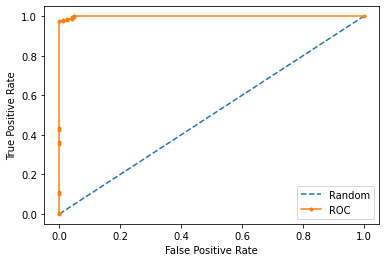

In [81]:
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(la))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(la, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(la, pr)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ROC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [28]:
# a
def visualize_model(model, num_images=16):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            thresh_preds = torch.round(torch.sigmoid(predictions))

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(f"Truth: {labels[j]}")
                ax.set_title('predicted: {}'.format("FAKE" if thresh_preds[j] == 1 else "REAL"))
            
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Truth: 1


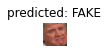

Truth: 0


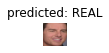

Truth: 0


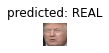

Truth: 0


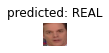

Truth: 0


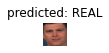

Truth: 0


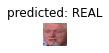

Truth: 0


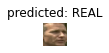

Truth: 1


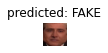

Truth: 1


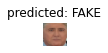

Truth: 1


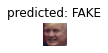

Truth: 1


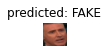

Truth: 1


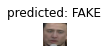

Truth: 0


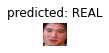

Truth: 0


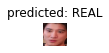

Truth: 0


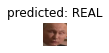

Truth: 0


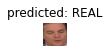

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
visualize_model(model)

In [24]:
import matplotlib.pyplot as plt

In [130]:
from torchvision import datasets, models, transforms

In [11]:
"""
from: https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/xception.py
Ported to pytorch thanks to [tstandley](https://github.com/tstandley/Xception-PyTorch)
@author: tstandley
Adapted by cadene
Creates an Xception Model as defined in:
Francois Chollet'
Xception: Deep Learning with Depthwise Separable Convolutions
https://arxiv.org/pdf/1610.02357.pdf
This weights ported from the Keras implementation. Achieves the following performance on the validation set:
Loss:0.9173 Prec@1:78.892 Prec@5:94.292
REMEMBER to set your image size to 3x299x299 for both test and validation
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
"""
from __future__ import print_function, division, absolute_import
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init

__all__ = ['xception']

pretrained_settings = {
    'xception': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000,
            'scale': 0.8975 # The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
        }
    }
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)

        # #------- init weights --------
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()
        # #-----------------------------

    def features(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        return x

    def logits(self, features):
        x = nn.ReLU(inplace=True)(features)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def xception(num_classes=1000, pretrained='imagenet'):
    model = Xception(num_classes=num_classes)
    if pretrained:
        settings = pretrained_settings['xception'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        model = Xception(num_classes=1)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']
        model.mean = settings['mean']
        model.std = settings['std']

    model.last_linear = model.fc
    del model.fc
    return model

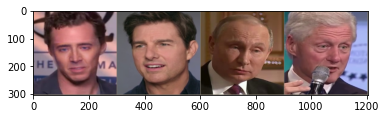

In [134]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [133]:
img, label = dataset[2]
print(img.shape)

torch.Size([3, 299, 299])


/home/jupyter/50margin/real/0000_19.jpg


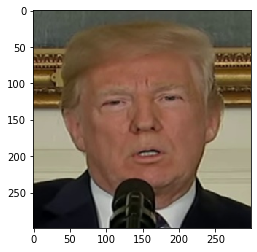

In [54]:
img, label = dataset[2]
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()